# Music Genre Classification with Machine Learning

The idea of this mini project is to deploy a music genre classifier into a web application. Music genre classification (MGC) has been a problem in music information retrieval (MIR) for a long time - starting with the problem of what a genre actually is. For this project, however, I assume that genre boundaries are somewhat known, and use a labeled dataset (GTZAN, Free Music Archive (FMA) or Audio set) to perform a multi-class classification using either CNN or classic ML techniques, depending on time constraints. 

For the CNN implementation, transfer learning can be done using the VGG-16 architecture with the fixed weights, or just as a starting point. The NN consists of 5 convolutional blocks, and the output layer would be a softmax activation. I would need to fetch the architecture, change the output layer, use regularization and dropout to reduce overfitting (reported by the reference) and feed the songs' spectrograms as inputs. 

For the ML implementation, I would have to manually extract the features. This would be done using the audio library librosa to extract frequency domain features (Mel-frequency Cepstral Coefficients (MFCC), Spectral Centroid, Spectral Roll-off...) and time domain features (Central moments, Zero Crossing Rate (ZCR), Root Means Squared Energy (RMSE)...). Those would then be fed into one or several classifiers for comparison (logistic regression, random forest, gradient boosting, support vector machines...).

The evaluation consists of standard accuracy, f-score and AUC scores.

Future project ideas could be speech classification or noise reduction, but both of those seem considerably more complex and less flexible (solely based on DL with RNN, LSTM and CNN with millions of parameters and extensive literature background).

Reference:
- Bahuleyan, Hareesh. Music Genre Classification using Machine Learning Techniques. University of Waterloo, 2018.

Extra references:
- Dataset: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

- Kaggle reference: https://www.kaggle.com/code/andradaolteanu/work-w-audio-data-visualise-classify-recommend#Machine-Learning-Classification

- Valerio Velardo's youtube channel - for understanding audio features and extractions

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, roc_curve, roc_auc_score
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance
import seaborn as sns
import tensorflow as tf
import eli5
from eli5.sklearn import PermutationImportance

# Audio Loading and Analyzing

In [54]:
# Loading audio files for visualization and analysis

classical_file = "../MusicGenreClassifier_MiniProject/Data/classical.00007.wav"
classical, sr = librosa.load(classical_file, duration=30)

ipd.Audio(classical_file)

In [55]:
blues_file = "../MusicGenreClassifier_MiniProject/Data/blues.00000.wav"
blues, _ = librosa.load(blues_file, duration=30)

ipd.Audio(blues_file)

In [56]:
metal_file = "../MusicGenreClassifier_MiniProject/Data/metal.00010.wav"
metal, _ = librosa.load(metal_file, duration=30)

ipd.Audio(metal_file)

In [57]:
blues

array([0.00732422, 0.01660156, 0.00762939, ..., 0.18188477, 0.1637268 ,
       0.15093994], dtype=float32)

In [58]:
blues.size

661500

# Time Domain Features

### Root-Mean-Squared Energy (RMSE)

- Taking the root-mean-square of all samples in a frame
- Indicator of loudness
- Less sensitive to outliers than 
- Audio segmentation (talking vs. music, different segments in a music piece), music genre classification

In [59]:
# Extract RMSE with librosa

FRAME_LENGTH = 2048
HOP_LENGTH = 512

rms_classical = librosa.feature.rms(
    classical, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
rms_blues = librosa.feature.rms(
    blues, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
rms_metal = librosa.feature.rms(
    metal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

rms_classical.shape

# Indexing the 0th row, so that the variable becomes an array we can plot

/var/folders/q8/4vkxmrxd0ng2pgpvstq96yhr0000gn/T/ipykernel_8941/3514816746.py:6: FutureWarning: Pass y=[-0.06890869 -0.10128784 -0.07559204 ...  0.07015991  0.07507324
  0.0798645 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rms_classical = librosa.feature.rms(
/var/folders/q8/4vkxmrxd0ng2pgpvstq96yhr0000gn/T/ipykernel_8941/3514816746.py:8: FutureWarning: Pass y=[0.00732422 0.01660156 0.00762939 ... 0.18188477 0.1637268  0.15093994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rms_blues = librosa.feature.rms(
/var/folders/q8/4vkxmrxd0ng2pgpvstq96yhr0000gn/T/ipykernel_8941/3514816746.py:10: FutureWarning: Pass y=[-0.18701172 -0.11355591 -0.06124878 ...  0.14407349 -0.04455566
 -0.00848389] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rms_metal = librosa.feature.rms(


(1292,)

<function matplotlib.pyplot.show(close=None, block=None)>

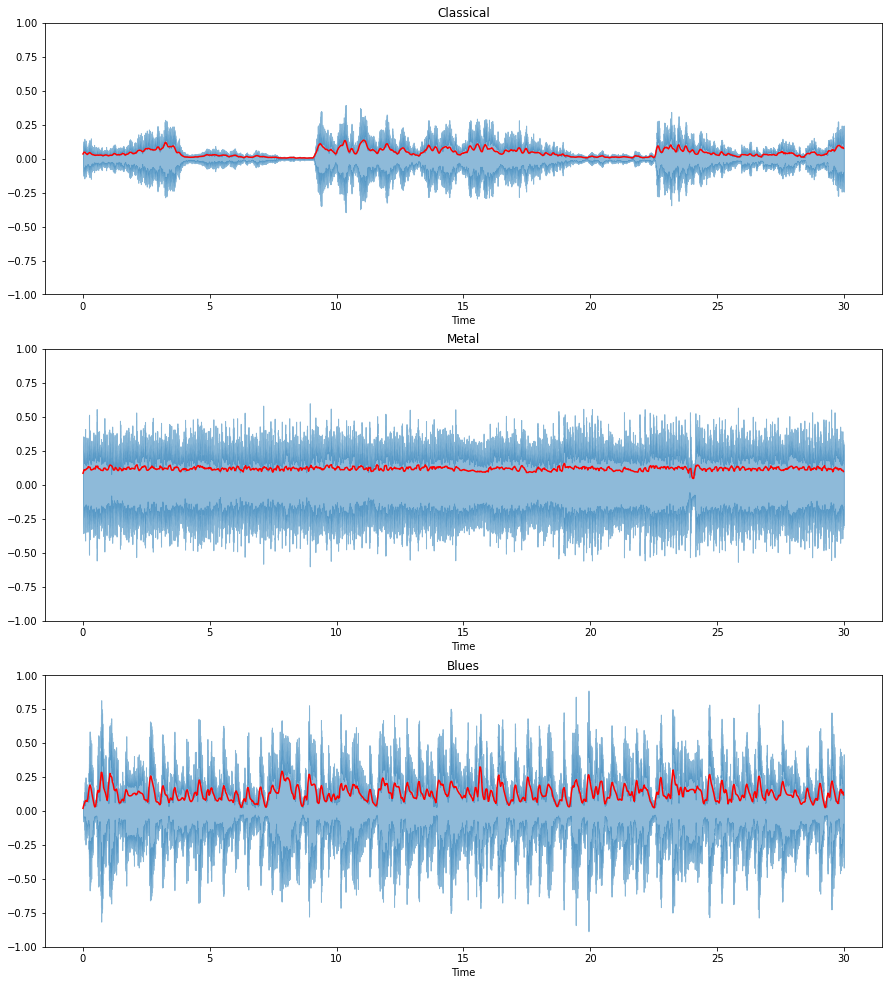

In [60]:
# Visualize the RMSE for all the audio files

frames = range(0, rms_blues.size)
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

plt.figure(figsize=(15, 17))

plt.subplot(3, 1, 1)
librosa.display.waveshow(classical, alpha=0.5)
plt.plot(t, rms_classical, color="r")
plt.title("Classical")  # alpha for transparency
plt.ylim((-1, 1))

plt.subplot(3, 1, 2)
librosa.display.waveshow(metal, alpha=0.5)
plt.plot(t, rms_metal, color="r")
plt.title("Metal")
plt.ylim((-1, 1))

plt.subplot(3, 1, 3)
librosa.display.waveshow(blues, alpha=0.5)
plt.plot(t, rms_blues, color="r")
plt.title("Blues")
plt.ylim((-1, 1))

plt.show

### Zero-Crossing Rate (ZCR)

In [61]:
# ZCR expressed with booleans

zcr_blues = librosa.zero_crossings(
    blues)
zcr_classical = librosa.zero_crossings(
    classical)
zcr_metal = librosa.zero_crossings(
    metal)

print(f"There are {sum(zcr_blues)} zero-crossing rates in the blues example,")
print(f"{sum(zcr_classical)} zero-crossing rates in the classical example and")
print(f"{sum(zcr_metal)} zero-crossing rates in the metal example")


There are 55013 zero-crossing rates in the blues example,
48446 zero-crossing rates in the classical example and
130189 zero-crossing rates in the metal example


<function matplotlib.pyplot.show(close=None, block=None)>

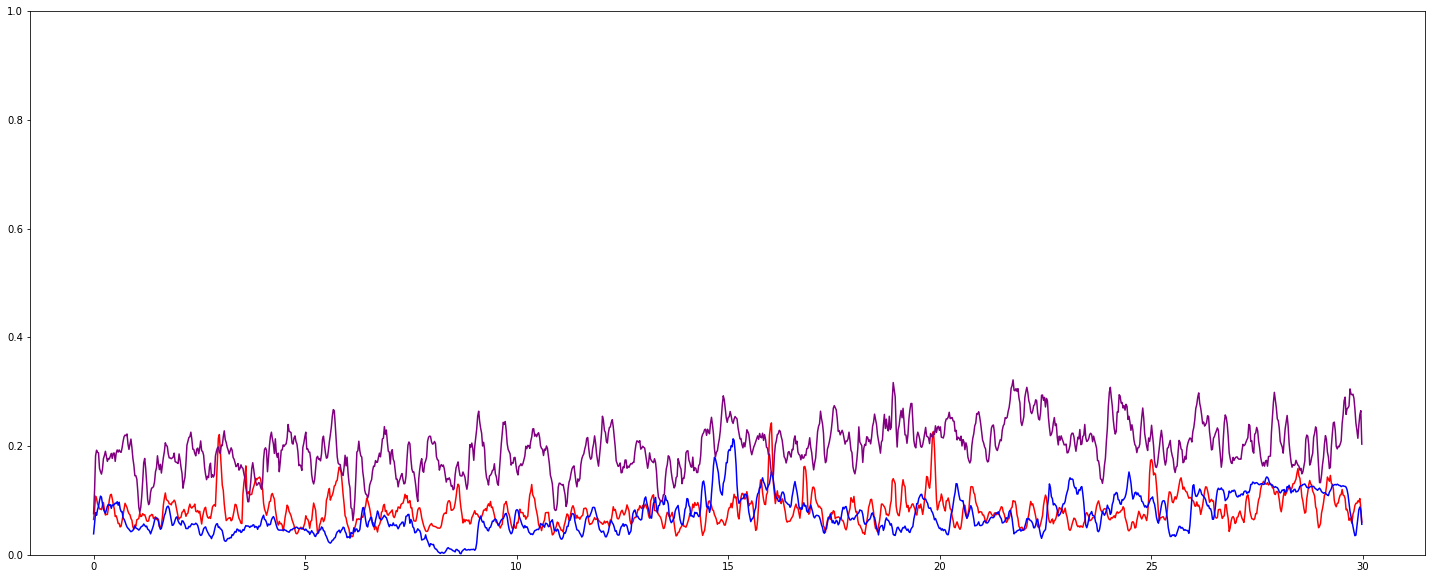

In [62]:
# Plot: visualize the zero-cossing rate for all files (normalized)

zcr_classical = librosa.feature.zero_crossing_rate(
    classical, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
zcr_blues = librosa.feature.zero_crossing_rate(
    blues, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
zcr_metal = librosa.feature.zero_crossing_rate(
    metal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

# Indexing the 0th row, so that the variable becomes an array we can plot

plt.figure(figsize=(25, 10))
plt.plot(t, zcr_blues, color="r")
plt.plot(t, zcr_classical, color="b")
plt.plot(t, zcr_metal, color="purple")
plt.ylim(0, 1)
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

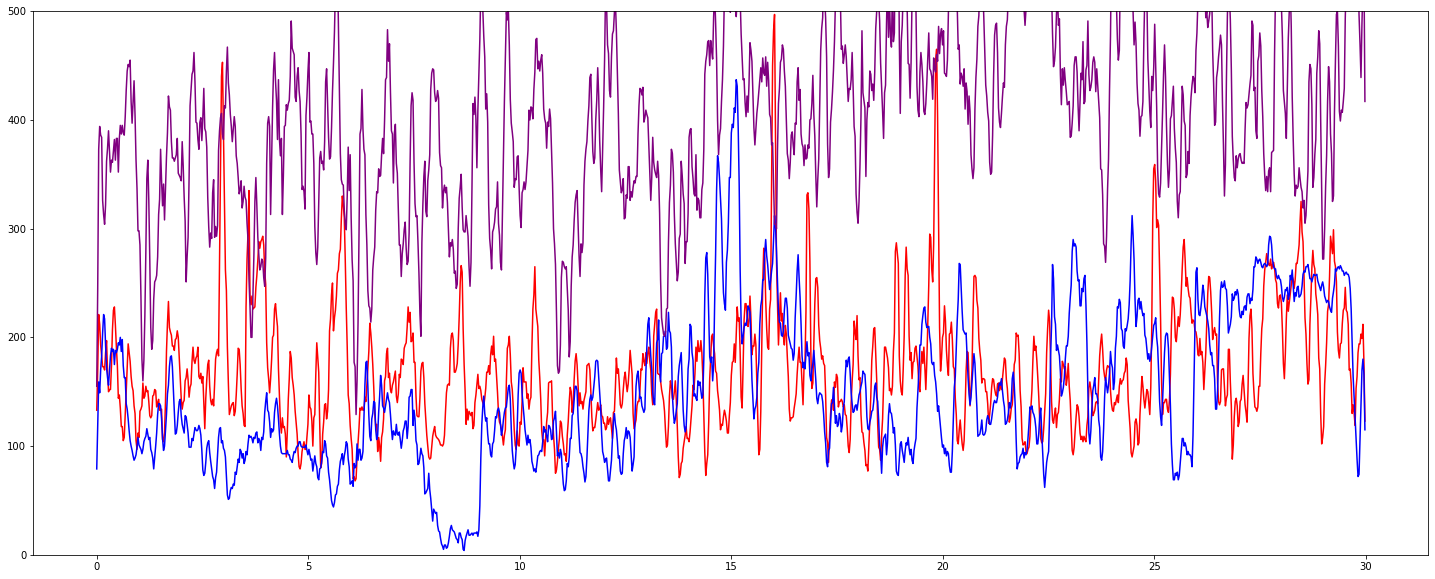

In [63]:
# Visualize the absolute number of zero-cossing rate for all files (zcr * FRAME_LENGTH)

plt.figure(figsize=(25, 10))
plt.plot(t, zcr_blues * FRAME_LENGTH, color="r")
plt.plot(t, zcr_classical * FRAME_LENGTH, color="b")
plt.plot(t, zcr_metal * FRAME_LENGTH, color="purple")
plt.ylim(0, 500)
plt.show

# Frequency-Domain Features

### Spectral centroid

- Centre of gravity of magnitude spectrum
- Frequency band where most of the energy is concentrated
- Measure of "brightness" of sound
- Weighted mean of all the frequency bins

SCt = (sum(mt(n) * n), from n=1 to N) / sum(mt(n), from n=1 to N)

sum of weights

- Used in audio and music classification

In [64]:
## Extracting Spectrograms

S_metal = np.abs(librosa.stft(metal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH))
S_classical = np.abs(librosa.stft(classical, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH))
S_blues = np.abs(librosa.stft(blues, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH))

S_metal.shape  # nr. of frequency bins by nr. of frames

(1025, 1292)

In [65]:
## Getting the Spectral Centroid

sc_metal = librosa.feature.spectral_centroid(
    y=metal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
sc_classical = librosa.feature.spectral_centroid(
    y=classical, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
sc_blues = librosa.feature.spectral_centroid(
    y=blues, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

sc_metal.shape


(1292,)

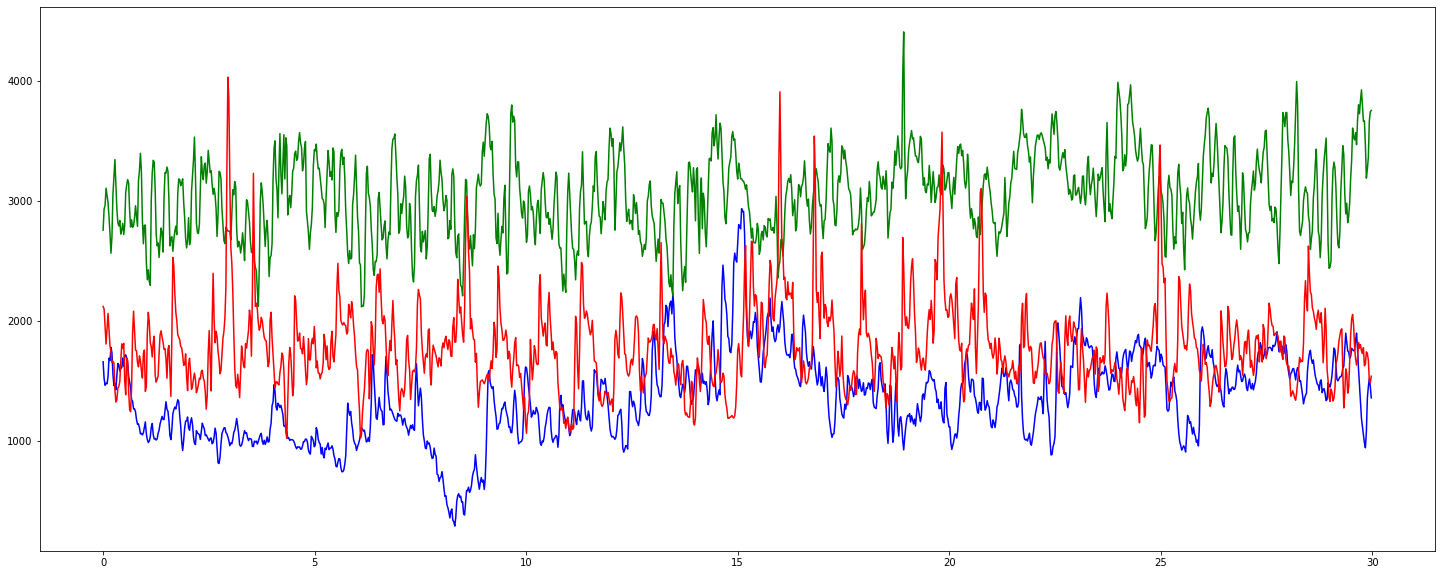

In [66]:
# Plotting Spectral Centroid

plt.figure(figsize=(25, 10))

plt.plot(t, sc_classical, color='b')
plt.plot(t, sc_metal, color='g')
plt.plot(t, sc_blues, color='r')

plt.show()

### Bandwidth
- Derived from spectral centroid
- Spectral range around the centroid
- Variance from the spectral centroid
- Describes perceived timbre
- Weighted mean of the distances of frequency bands from SC
- Also known as the spectral spread

BWt = sum( | n - SCt | * mt(n), from n=1 to N) / sum(mt(n), from n=1 to N)

|n - SCt | = Distance of frequency band from spectral centroid
mt(n) = Weight for n

higher energy spread across frequency bands = higher BWt
lower energy spread across frequency bands = lower BWt


In [67]:
bw_metal = librosa.feature.spectral_bandwidth(
    y=metal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
bw_classical = librosa.feature.spectral_bandwidth(
    y=classical, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
bw_blues = librosa.feature.spectral_bandwidth(
    y=blues, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

bw_metal.shape

(1292,)

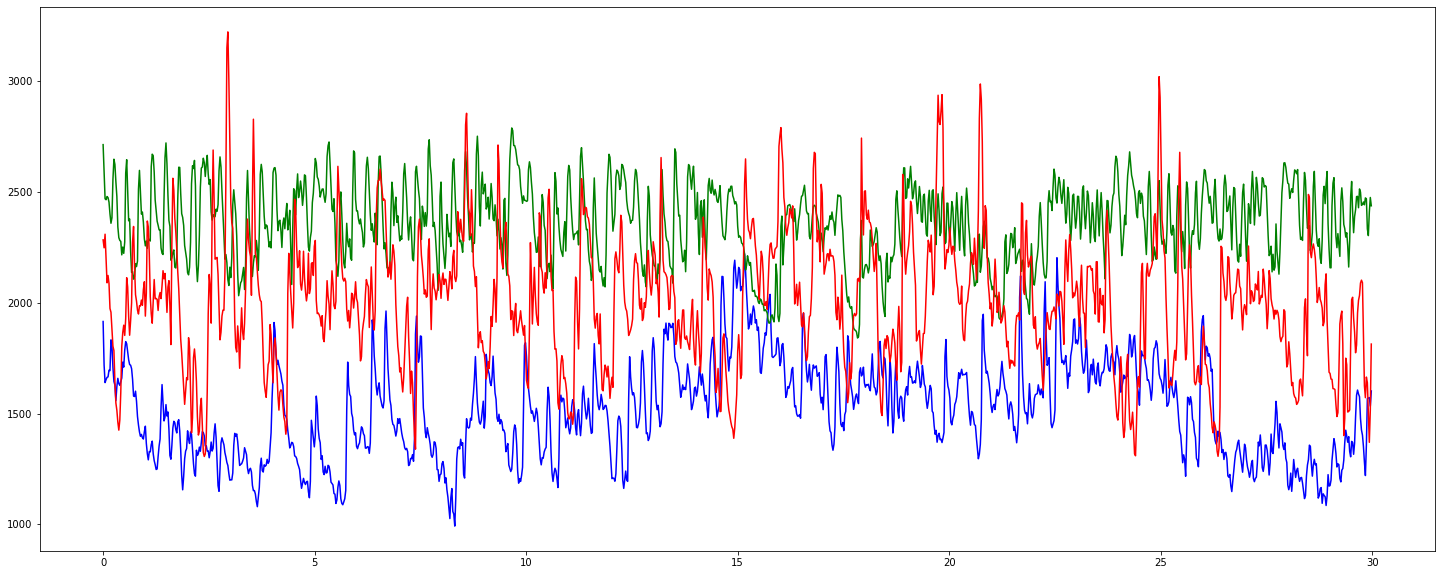

In [68]:
plt.figure(figsize=(25, 10))

plt.plot(t, bw_classical, color='b')
plt.plot(t, bw_metal, color='g')
plt.plot(t, bw_blues, color='r')

plt.show()

### Spectral Rolloff

From Librosa: 

Compute roll-off frequency.

The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below. This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent to a value close to 1 (or 0).

In [69]:
spectral_rolloff_metal = librosa.feature.spectral_rolloff(metal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
spectral_rolloff_classical = librosa.feature.spectral_rolloff(classical, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
spectral_rolloff_blues = librosa.feature.spectral_rolloff(blues, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

print(spectral_rolloff_metal.shape)

(1292,)


/var/folders/q8/4vkxmrxd0ng2pgpvstq96yhr0000gn/T/ipykernel_8941/4220991896.py:1: FutureWarning: Pass y=[-0.18701172 -0.11355591 -0.06124878 ...  0.14407349 -0.04455566
 -0.00848389] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_rolloff_metal = librosa.feature.spectral_rolloff(metal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
/var/folders/q8/4vkxmrxd0ng2pgpvstq96yhr0000gn/T/ipykernel_8941/4220991896.py:2: FutureWarning: Pass y=[-0.06890869 -0.10128784 -0.07559204 ...  0.07015991  0.07507324
  0.0798645 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_rolloff_classical = librosa.feature.spectral_rolloff(classical, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
/var/folders/q8/4vkxmrxd0ng2pgpvstq96yhr0000gn/T/ipykernel_8941/4220991896.py:3: FutureWarning: Pass y=[0.00732422 0.01660156 0.00762939 ... 0.18188477 0.1637268  0.15093994] as keyword args. Fr

<function matplotlib.pyplot.show(close=None, block=None)>

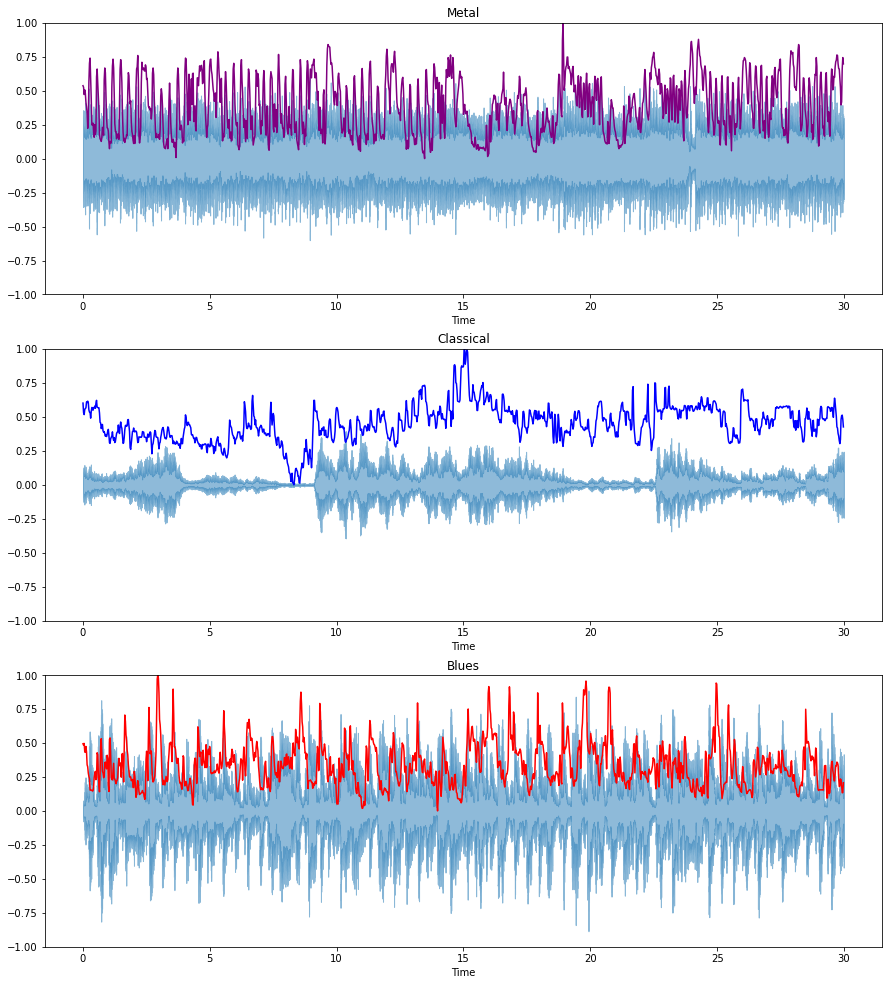

In [70]:
# Plotting the Spectral-Rolloff

plt.figure(figsize=(15, 17))

plt.subplot(3, 1, 1)
librosa.display.waveshow(metal, alpha=0.5)
plt.plot(t, preprocessing.minmax_scale(
    spectral_rolloff_metal, axis=0), color="purple")
plt.title("Metal")  # alpha for transparency
plt.ylim((-1, 1))

plt.subplot(3, 1, 2)
librosa.display.waveshow(classical, alpha=0.5)
plt.plot(t, preprocessing.minmax_scale(
    spectral_rolloff_classical, axis=0), color="b")
plt.title("Classical")
plt.ylim((-1, 1))

plt.subplot(3, 1, 3)
librosa.display.waveshow(blues, alpha=0.5)
plt.plot(t, preprocessing.minmax_scale(
    spectral_rolloff_blues, axis=0), color="r")
plt.title("Blues")
plt.ylim((-1, 1))

plt.show


# Mel-Frequency Cepstral Coeficients (MFCCs)

- Using the mel-scale, which is perceptually relevant for pitch
- Cepstral, from Cepstrum - inverse of Spectrum 
- Coefficients - out of these features we get a number of values that describe sound

Other wordplay examples:
- Quefrency (from Frequency)
- Liftering (from Filtering)
- Rhamonic (from Harmonic)

C(x(t)) = F^-1 * [log(F[x(t)])] , where

x(t) is a signal in the time domain, F is a discrete fourier transform (DFT), which shifts x(t) from the time domain to the frequency domain (Spectrum). Apply logarithm to the spectrum to get the log amplitude spectrum, which is closer to human perception of amplitude. Finally, apply an inverse DFT to that to get the Cepstrum. This means taking a log amplitude spectrum and calculating a spectrum of that.

Signal --> (DFT) --> Power spectrum --> (log) --> Magnitude (log power) spectrum

The magnitude spectrum has some periodicity in the frequency components, because of the periodicity of the harmonic series. By treating it as a signal and applying the inverse DFT, we get a Cesptrum. From time domain applying the DFT you get frequency on the x-axis. From Log power spectrum, applying a IDFT, we get a Cepstrum, with 'Quefrency (ms)' in the x-axis and 'Absolute Magnitude' in the y-axis. The example graph shows a peak in the 1st 'Rhamonic'- it represents the harmonic structure present in the original signal.

### Understanding Speech generation
- Glottal pulses
- The vocal tract acts as a filter
- Speech signal (modified by the vocal tract)


### Understanding the cepstrum

- Log-spectrum for speech

- Spectral envelope (basicaly an Amplitude Envelope in the frequency domain, to smoothen out the original log-spectrum)
- The peaks present in the spectral envelope represents the formants. They carry the identity of sound - it carries important information about it.
- Shaping the vocal tract differently gives different frequency responses, which gives timbres - different sound identities.

- The spectral detail is the rest of the signal. It carries information about the glotal pulse.

--> Speech = Convolution of the vocal tract frequency response with the glottal pulse


### Formalising speech

x(t) = e(t) * h(t) # e(t) from glotal pulse, h(t) from the vocal tract

X(t) = E(t) * H(t)


### By applying the log, we can treat the two portions separately

log(X(t)) = log(E(t) * H(t))  
log(X(t)) = log(E(t)) + log(H(t))

Speech = Glottal pulse + Vocal tract frequency response
The goal: Separating components. The formants and vocal tract frequency response components are the key.

- The cepstrum will have a peak at the frequency of the number of peaks in the speech signal (e.g. 4 Hz, representing the vocal tract frequency response; the spectral envelop), and a higher, separated frequency (e.g. 100Hz, representing the glottal pulse, in the spectral detail).

- To isolate the features from the spectrum envelope, we need to apply a low-pass lifter (filter in the cepstrum) to remove the spectral detail information.


### Computing Mel-Frequency Cesptral Coefficients (MFCCs)

- Waveform
- DFT # moving to the frequency domain
- Log-Amplitude Spectrum # applying log to make it more perceptually informed in terms of loudness
- applying Mel-Scaling (applying the mel filter banks, triangular filters) # more perceptually informed in terms of frequency
- applying the Discrete Cosine Transform (similar to IDFT) # 
- MFCCs


### Why Discrete Cosine Transform?
- Simplified version of Fourier Transform
- Returns only real-valued coefficients
- Decorrelate energy in different mel bands
--> There's some overlap; information is sharedd across multiple mel bands. The discrete cosine transform helps to decorrelate this information, which is especially useful for machine learning applications - we want features that are as list correlated as possible.
- Reduce the number of dimensions to represent spectrum


### How many coefficients?
- Traditionally: first 12-13 coefficients # contains information about formants and envelopes. The ones in the lower end provide information about the spectral envelope; higher end = fast changing spectral detail
- First coefficients keep most information
- To help ML algorithms: Taking the first and second derivatives of MFCCs (first and second deltas). Subtracting values from MFCCs from the previous frame to the current frame to get the difference (delta), as well as the previous previous frame. This means we need around 39 coefficients per frame.


### Visualising MFCCs
- matrixes with coefficients x frames
- can be visualized as spectrograms


### MFCCs characteristics
Pros:
- Describe the "large" structures of the spectrum - the spectral envelope; the formants
- Ignore fine spectral structures (e.g. pitch), which is not important for speech recognition for examples.
- Work well with speech and music processing

Cons:
- Not robust to noise
- Extensive knowledge engineering - meaning it can be seen as a biased audio feature, instead of letting the machine extract features with less biases
- Great for analysis, but not efficient for synthesis. We are not capable of shifting from MFCCs to audio.

Applications: 
- Speech processing - recognition, speaker recognition
- Music processing - music genre classification, mood classification, automatic tagging...

--> very good for timbral characteristics, pitch invariant

In [71]:
#Exctracting MFCCs

mfccs_metal = librosa.feature.mfcc(metal, n_mfcc=13, sr=sr)
mfccs_classical = librosa.feature.mfcc(classical, n_mfcc=13, sr=sr)
mfccs_blues = librosa.feature.mfcc(blues, n_mfcc=13, sr=sr)

mfccs_metal.shape

/var/folders/q8/4vkxmrxd0ng2pgpvstq96yhr0000gn/T/ipykernel_8941/1749993816.py:3: FutureWarning: Pass y=[-0.18701172 -0.11355591 -0.06124878 ...  0.14407349 -0.04455566
 -0.00848389] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs_metal = librosa.feature.mfcc(metal, n_mfcc=13, sr=sr)
/var/folders/q8/4vkxmrxd0ng2pgpvstq96yhr0000gn/T/ipykernel_8941/1749993816.py:4: FutureWarning: Pass y=[-0.06890869 -0.10128784 -0.07559204 ...  0.07015991  0.07507324
  0.0798645 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs_classical = librosa.feature.mfcc(classical, n_mfcc=13, sr=sr)
/var/folders/q8/4vkxmrxd0ng2pgpvstq96yhr0000gn/T/ipykernel_8941/1749993816.py:5: FutureWarning: Pass y=[0.00732422 0.01660156 0.00762939 ... 0.18188477 0.1637268  0.15093994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs_blues = librosa.feature.mfcc(b

(13, 1292)

<function matplotlib.pyplot.show(close=None, block=None)>

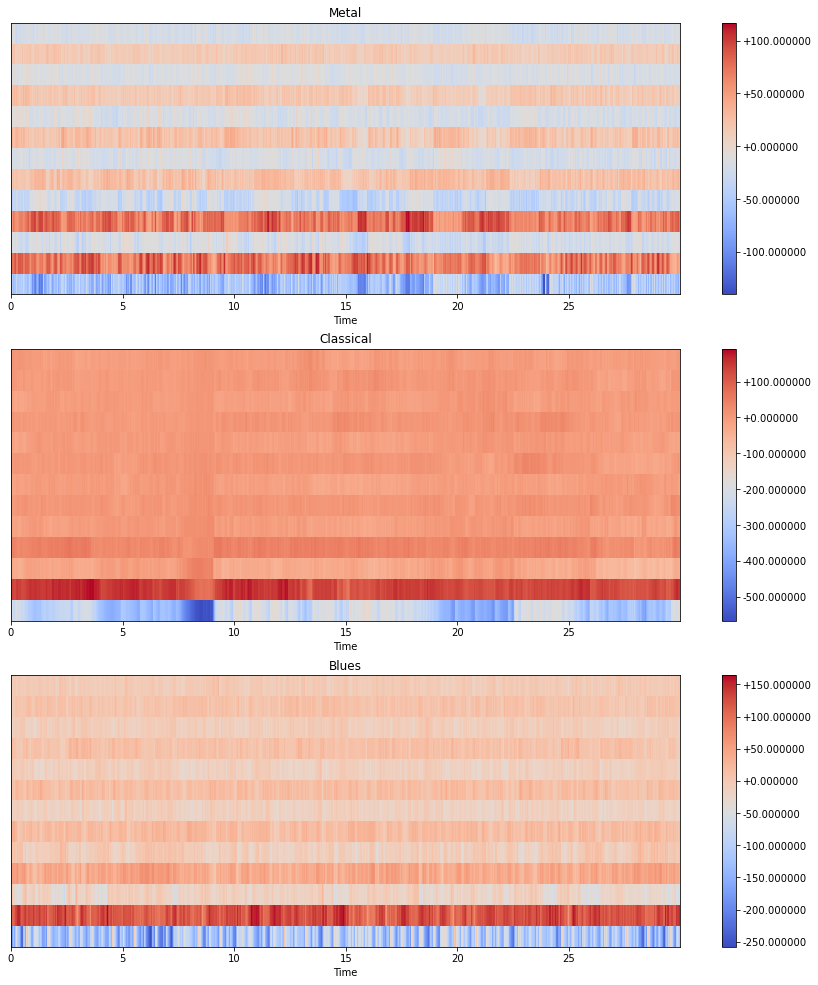

In [72]:
# Plotting the MFCCs
plt.figure(figsize=(15, 17))

plt.subplot(3, 1, 1)
librosa.display.specshow(mfccs_metal, x_axis='time', sr=sr)
plt.colorbar(format='%+2f')
plt.title("Metal")

plt.subplot(3, 1, 2)
librosa.display.specshow(mfccs_classical, x_axis='time', sr=sr)
plt.colorbar(format='%+2f')
plt.title("Classical")

plt.subplot(3, 1, 3)
librosa.display.specshow(mfccs_blues, x_axis='time', sr=sr)
plt.colorbar(format='%+2f')
plt.title("Blues")

plt.show


# Music specific Features

### Tempo

In [73]:
# Estimate a static tempo - time domain feature

onset_env_metal = librosa.onset.onset_strength(y=metal, sr=sr)
onset_env_classical = librosa.onset.onset_strength(y=classical, sr=sr)
onset_env_blues = librosa.onset.onset_strength(y=blues, sr=sr)

tempo_metal = librosa.beat.tempo(onset_envelope=onset_env_metal, sr=sr)
tempo_classical = librosa.beat.tempo(onset_envelope=onset_env_classical, sr=sr)
tempo_blues = librosa.beat.tempo(onset_envelope=onset_env_blues, sr=sr)

print(f"tempo for the metal track: {tempo_metal}, classical track: {tempo_classical} and blues track: {tempo_blues}")

tempo for the metal track: [129.19921875], classical track: [107.66601562] and blues track: [123.046875]


### Chroma STFT

In [74]:
# Frequency domain feature using magnitude spectrograms

chroma_metal = librosa.feature.chroma_stft(S=S_metal, sr=sr)
chroma_classical = librosa.feature.chroma_stft(S=S_classical, sr=sr)
chroma_blues = librosa.feature.chroma_stft(S=S_blues, sr=sr)

chroma_metal

array([[0.9287074 , 0.8768946 , 0.9744756 , ..., 0.75212175, 0.7320106 ,
        0.6734599 ],
       [0.83850974, 0.7534726 , 0.9482896 , ..., 0.8140143 , 0.7632927 ,
        0.76350844],
       [0.79933643, 0.6902907 , 0.7891974 , ..., 1.        , 0.92868185,
        0.9603967 ],
       ...,
       [0.95196074, 0.8356457 , 0.81038016, ..., 0.80194265, 0.8840098 ,
        0.8338503 ],
       [1.        , 0.99630535, 0.95199543, ..., 0.8534292 , 0.8428574 ,
        0.7107372 ],
       [0.9746191 , 1.        , 1.        , ..., 0.7650148 , 0.74290675,
        0.6822941 ]], dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

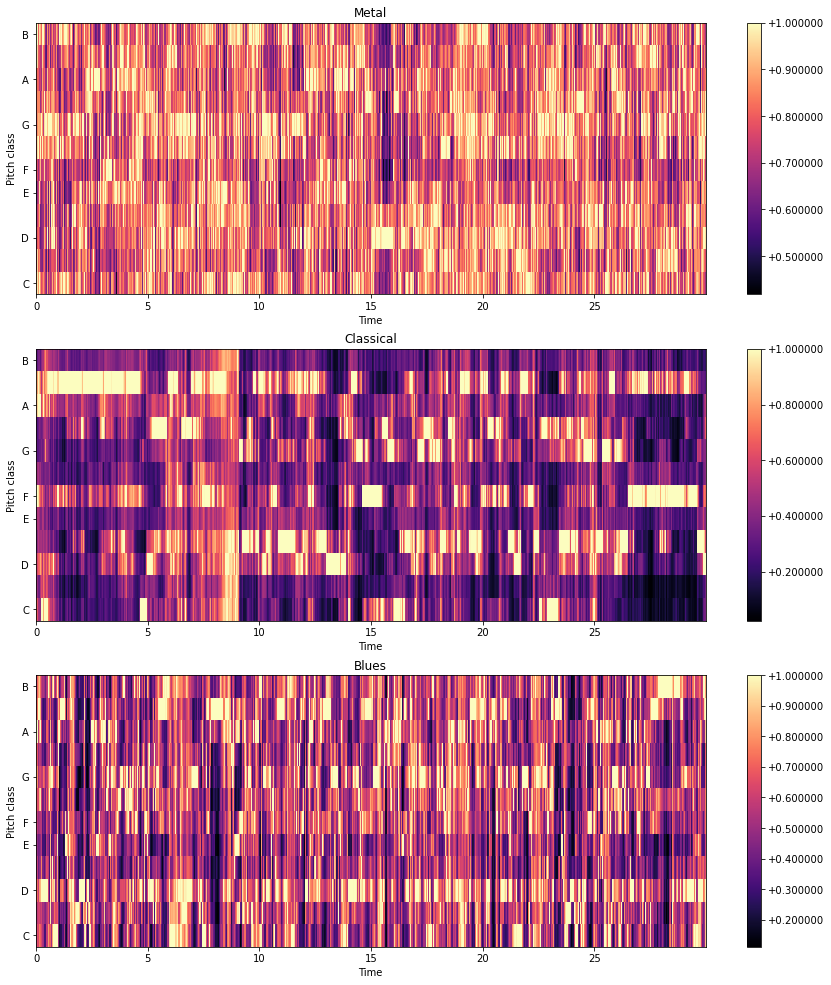

In [75]:
# Plotting the Chroma STFTs

plt.figure(figsize=(15, 17))

plt.subplot(3, 1, 1)
img_chroma_metal = librosa.display.specshow(
    chroma_metal, y_axis='chroma', x_axis='time')#, ax=ax[0])
plt.colorbar(format='%+2f')
plt.title("Metal")

plt.subplot(3, 1, 2)
img_chroma_classical = librosa.display.specshow(
    chroma_classical, y_axis='chroma', x_axis='time')#, ax=ax[1])
plt.colorbar(format='%+2f')
plt.title("Classical")

plt.subplot(3, 1, 3)
img_chroma_blues = librosa.display.specshow(
    chroma_blues, y_axis='chroma', x_axis='time')#, ax=ax[2])
plt.colorbar(format='%+2f')
plt.title("Blues")

plt.show

### Harmonics

<function matplotlib.pyplot.show(close=None, block=None)>

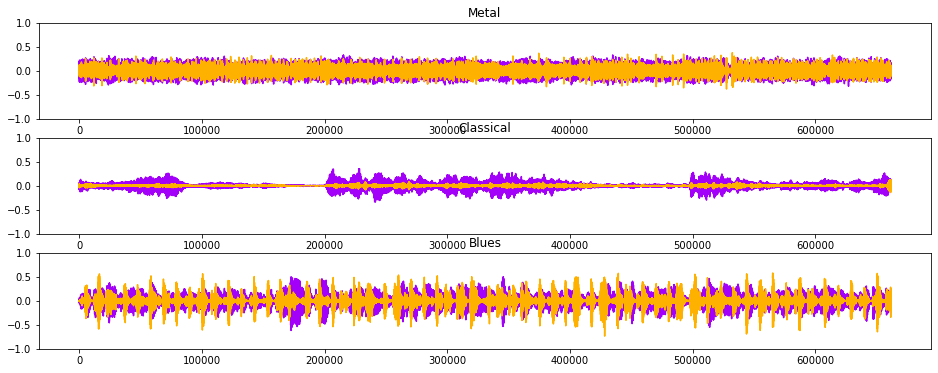

In [76]:
# Extract harmonic and percussive components; time-domain feature

harmonic_metal, percussive_metal = librosa.effects.hpss(metal)
harmonic_classical, percussive_classical = librosa.effects.hpss(classical)
harmonic_blues, percussive_blues = librosa.effects.hpss(blues)

plt.figure(figsize=(16, 6))

plt.subplot(3, 1, 1)
plt.plot(harmonic_metal, color='#A300F9')
plt.plot(percussive_metal, color='#FFB100')
plt.title("Metal")
plt.ylim((-1, 1))

plt.subplot(3, 1, 2)
plt.plot(harmonic_classical, color='#A300F9')
plt.plot(percussive_classical, color='#FFB100')
plt.title("Classical")
plt.ylim((-1, 1))

plt.subplot(3, 1, 3)
plt.plot(harmonic_blues, color='#A300F9')
plt.plot(percussive_blues, color='#FFB100')
plt.title("Blues")
plt.ylim((-1, 1))

plt.show

# Machine Learning Classification

In [77]:
# Importing the data set CSV - using the 3 sec dataset for 10x more data compared to the 30 sec

data = pd.read_csv("../MusicGenreClassifier_MiniProject/Data/features_3_sec.csv")
data.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

## Data Preprocessing

In [78]:
# Dropping the length and filename columns
data = data.drop(
    ['length', 'filename', 'perceptr_mean', 'perceptr_var', 'harmony_mean', 'harmony_var'], axis=1)

y = data['label']  # Getting the label column

# Input (X): All columns except for label
X = data.loc[:, data.columns != 'label']

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (9990, 53), y shape: (9990,)


In [79]:
X.head

<bound method NDFrame.head of       chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0             0.335406         0.091048  0.130405  0.003521   
1             0.343065         0.086147  0.112699  0.001450   
2             0.346815         0.092243  0.132003  0.004620   
3             0.363639         0.086856  0.132565  0.002448   
4             0.335579         0.088129  0.143289  0.001701   
...                ...              ...       ...       ...   
9985          0.349126         0.080515  0.050019  0.000097   
9986          0.372564         0.082626  0.057897  0.000088   
9987          0.347481         0.089019  0.052403  0.000701   
9988          0.387527         0.084815  0.066430  0.000320   
9989          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              1972.744388   
1                1816.693777           90525.690866  

In [80]:
# Using LabelEncoder to transform genres into numerical values

le = preprocessing.LabelEncoder()
le.fit(y)
y_le = le.transform(y) # transforms the labels into numerical values
# le.inverse_transform(y) # retrieves the original labels afterwards

print(f"The label encoded output y_le is: {y_le}, original classes: {le.classes_}")

The label encoded output y_le is: [0 0 0 ... 9 9 9], original classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [81]:
# from https://www.kaggle.com/code/andradaolteanu/work-w-audio-data-visualise-classify-recommend

# Normalize so everything is on the same scale (0 - 1). Normalizing increased the accuracy by almost 20%
# with e.g. logistic regression
# obs: the audio files would ideally also be normalized before the feature extraction.

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

In [82]:
# Splitting the data into train, cross-validation and test using sklearn

X_train, X_, y_train, y_ = train_test_split(X, y_le, test_size=0.3, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=1)

print(f"X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
print(f"X_cv.shape", X_cv.shape, "y_cv.shape:", y_cv.shape)
print("X_test.shape:", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape: (6993, 53) y_train.shape: (6993,)
X_cv.shape (1498, 53) y_cv.shape: (1498,)
X_test.shape: (1499, 53) y_test.shape (1499,)


## Assessing different models

In [83]:
def model_assess (model, title = "Default"):
    model.fit(X_train, y_train)
    #predictions = model.predict(X_cv)
    #print('Accuracy', title, ':', round(accuracy_score(y_test, predictions), 5), '\n')
    accuracy = model.score(X_cv, y_cv)
    print(f"Accuracy for {title} is {format(accuracy)}")


In [84]:
# Logistic Regression

# similar results with linear and lbfgs solvers
# (acc for lbfgs = 0.53)

logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000)
model_assess(logistic_regression, "Logistic Regression")


# Support Vector Machine
svm_svc = SVC(decision_function_shape="ovo", probability=True)
model_assess(svm_svc, "Support Vector Machine")


# Random Forest

# Best results achieved not limiting the max_depth and with number of trees in the forest n_estimators=114
# meaning 2 * n_features = 2 * 57 = 114 ; faster than xgb, slightly lower accuracy

random_forest = RandomForestClassifier(n_estimators=114, random_state=0)
model_assess(random_forest, "Random Forest")


# Extreme Gradient Boost (XGBoost)
# Increased chance of working on the misclassified examples

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# n_estimators=1000, learning_rate=0.05 - Accuracy = 0.9
# n_estimators=1000, learning_rate=0.5 - Accuracy = 0.88
# n_estimators=1000, learning_rate=0.005 - Accuracy = 0.82

Accuracy for Logistic Regression is 0.6869158878504673
Accuracy for Support Vector Machine is 0.7389853137516689
Accuracy for Random Forest is 0.8304405874499332
Accuracy for Cross Gradient Booster is 0.8658210947930574


## Scores and Reports

In [85]:
# Checking for individual accuracy, using Microsoft's function

# Single row test
cv_test = X_cv.iloc[50].values.reshape(-1, 1).T

y_cv_scores = xgb.predict_proba(X_cv) #cv_test for the single row test
y_test_scores = xgb.predict_proba(X_test)
classes = xgb.classes_
resultdf = pd.DataFrame(data=y_cv_scores, columns=classes)

topPrediction = resultdf.T.sort_values(by=[0], ascending = [False])
topPrediction

0         1         2         3         4         5     \
5  9.998744e-01  0.000011  0.000013  0.000033  0.000003  0.007755   
0  5.013176e-05  0.002443  0.000005  0.011985  0.001436  0.000166   
2  2.276721e-05  0.000346  0.000794  0.000789  0.000068  0.013978   
9  2.050501e-05  0.000773  0.000059  0.004075  0.000100  0.180025   
1  1.705922e-05  0.000013  0.000008  0.000092  0.000010  0.001040   
3  5.721054e-06  0.000352  0.000020  0.743403  0.000210  0.557856   
6  4.789547e-06  0.996002  0.000005  0.003464  0.987921  0.000223   
8  3.273029e-06  0.000006  0.998384  0.000411  0.000034  0.003658   
4  8.478420e-07  0.000052  0.000708  0.235675  0.010216  0.000941   
7  5.491785e-07  0.000003  0.000003  0.000073  0.000002  0.234358   

           6         7         8         9     ...          1488  \
5  1.257525e-07  0.000006  0.000217  0.110481  ...  1.828333e-07   
0  2.343587e-07  0.001043  0.005411  0.000689  ...  4.068982e-06   
2  5.878788e-07  0.002463  0.010311  0.085523  ...  3.901232e-05   
9  3.059905e-06  0.020261  0.021883  0.797849  ...  8.301214e-04   
1  1.220538e-06  0.000054  0.000080  0.000067  ...  7.144756e-07   
3  5.410996e-04  0.975486  0.009756  0.002596  ...  9.981128e-01   
6  1.854544e-06  0.000465  0.001884  0.002110  ...  1.003927e-05   
8  2.115835e-05  0.000018  0.931243  0.000348  ...  1.710142e-04   
4  2.128092e-04  0.000191  0.019160  0.000284  ...  8.316353e-04   
7  9.992179e-01  0.000012  0.000057  0.000053  ...  3.921064e-07   

           1489      1490      1491          1492      1493      1494  \
5  1.365267e-04  0.000417  0.000229  9.093866e-07  0.000073  0.000002   
0  1.137488e-05  0.000141  0.000014  1.401052e-05  0.995612  0.000007   
2  2.804254e-05  0.997549  0.960031  6.821418e-05  0.000336  0.000005   
9  1.471766e-05  0.000156  0.000251  1.235002e-04  0.000542  0.001168   
1  9.998042e-01  0.000164  0.000377  3.099302e-06  0.000004  0.000007   
3  2.392559e-06  0.000790  0.000639  4.023113e-04  0.000526  0.994021   
6  6.044527e-07  0.000088  0.000009  9.992385e-01  0.002880  0.000009   
8  1.309997e-06  0.000036  0.031364  9.606543e-06  0.000011  0.002690   
4  5.764593e-07  0.000157  0.000187  1.391690e-04  0.000011  0.001577   
7  2.311572e-07  0.000503  0.006898  7.433311e-07  0.000004  0.000515   

           1495      1496      1497  
5  6.547376e-03  0.089853  0.097354  
0  9.933649e-01  0.005293  0.445422  
2  5.677587e-05  0.003536  0.454876  
9  1.840550e-05  0.000711  0.001472  
1  1.169538e-06  0.894929  0.000131  
3  8.494462e-07  0.005120  0.000183  
6  7.499934e-07  0.000054  0.000058  
8  1.017786e-06  0.000274  0.000321  
4  7.961228e-06  0.000134  0.000094  
7  7.893772e-07  0.000095  0.000089  

[10 rows x 1498 columns]

In [86]:
# Calculating Receiving Operating Characteristic (ROC)'s 
# 'Area Under the Curve' (AUC) score using the previous y_cv_scores

auc = roc_auc_score(y_cv, y_cv_scores, multi_class='ovr') # y_cv_scores[:, 1]
print(auc)

0.98810669804316


In [87]:
# Classification report for cross validation

y_predict = xgb.predict(X_test)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       147
           1       0.95      0.98      0.97       141
           2       0.80      0.85      0.82       138
           3       0.80      0.85      0.82       142
           4       0.88      0.88      0.88       169
           5       0.90      0.91      0.90       141
           6       0.91      0.97      0.94       144
           7       0.93      0.88      0.90       156
           8       0.92      0.87      0.89       167
           9       0.84      0.77      0.81       154

    accuracy                           0.88      1499
   macro avg       0.88      0.88      0.88      1499
weighted avg       0.88      0.88      0.88      1499



In [88]:
print('Accuracy logistic_regression:', round(accuracy_score(y_cv, logistic_regression.predict(X_cv)), 5), '\n')
print('Accuracy svm_svc:', round(accuracy_score(y_cv, svm_svc.predict(X_cv)), 5), '\n')
print('Accuracy random_forest:', round(accuracy_score(y_cv, random_forest.predict(X_cv)), 5), '\n')
print('Accuracy xgb:', round(accuracy_score(y_cv, xgb.predict(X_cv)), 5), '\n')

Accuracy logistic_regression: 0.68692 

Accuracy svm_svc: 0.73899 

Accuracy random_forest: 0.83044 

Accuracy xgb: 0.86582 



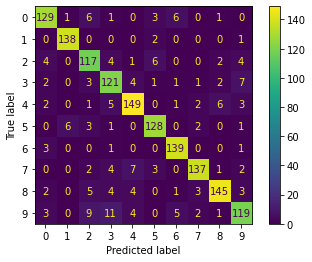

In [89]:
# Scikit confusion matrix

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
plt.show()

Accuracy: 0.88192 



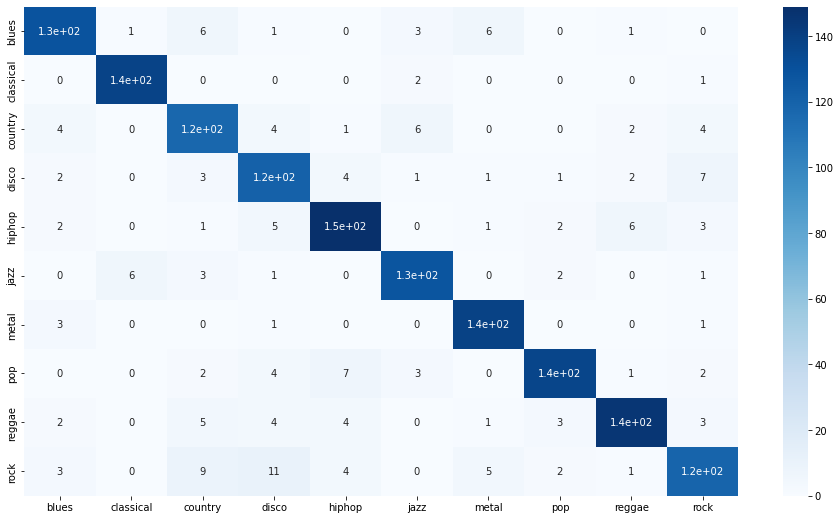

In [90]:
print('Accuracy:', round(accuracy_score(y_test, y_predict), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, y_predict) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])
plt.savefig("conf matrix")

In [91]:
# Permutation importance

perm = PermutationImportance(estimator=xgb, random_state=1)
perm.fit(X_test, y_test)

eli5.show_weights(estimator=perm, feature_names=X_test.columns.tolist())

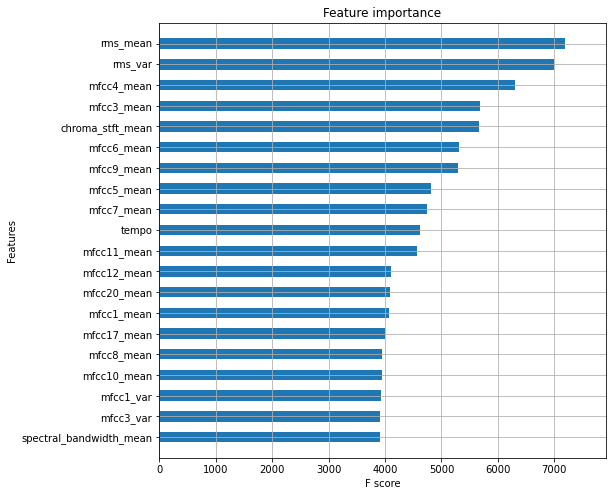

In [92]:
# Feature importance

ax = plot_importance(
    xgb, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
# plt.savefig('plots/feature-imp.png', bbox_inches='tight')
